In [1]:
import pandas as pd

colunas = ['PROCESSO', 'EMENTA', 'ROTULO_MANUAL']

df = pd.read_csv('../data/ementas_rotulos_manual.csv', header=0, sep=',', quotechar='"', usecols=colunas)

In [2]:
df.head()

,PROCESSO,EMENTA,ROTULO_MANUAL
0,00024255420138240081,<br> APELAÇÃO CÍVEL. AÇÃO DE INDENIZAÇÃO POR...,DAN
1,00103872520108240020,<br> APELAÇÃO CÍVEL. AÇÃO DE RESCISÃO CONTRA...,CON
2,00103872520108240020,<br> EMBARGOS DE DECLARAÇÃO EM APELAÇÃO CÍVE...,CON
3,00067390720078240064,<br> EMBARGOS DE DECLARAÇÃO EM APELAÇÃO CÍVE...,PRE
4,00067390720078240064,<br> EMBARGOS DE DECLARAÇÃO EM APELAÇÃO CÍVE...,PRE


In [3]:
def tratar_texto(texto):
    texto = texto.lower()
    texto = texto.replace('<br>', '')
    return texto

In [4]:
import string

remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def remover_pontuacao(texto):
    return texto.translate(remove_punctuation_map)

In [10]:
from stop_words import get_stop_words

stop_words_pt = get_stop_words("pt")

def remover_stop_words(texto):
    words = [word for word in texto.split() if len(word) > 1 and word not in stop_words_pt]
    return ' '.join(words)

In [11]:
import re
from nltk import tokenize
from unidecode import unidecode

def normalizar(texto):
    texto = tratar_texto(texto)
    texto = remover_pontuacao(texto)
           
    # quebra em palavras
    texto = remover_stop_words(texto)
    
    # remover acentuação
    texto = unidecode(texto)
    
    #removendo números
    texto = re.sub('[^a-zA-Z ]+', '', texto)

    return texto

In [12]:
df['EMENTA'][1]

'<br>   APELAÇÃO CÍVEL. AÇÃO DE RESCISÃO CONTRATUAL CUMULADA COM INDENIZAÇÃO POR PERDAS E DANOS E REINTEGRAÇÃO DE POSSE. CONTRATO PARTICULAR DE COMPROMISSO DE COMPRA E VENDA DE BEM IMÓVEL. INADIMPLEMENTO ATRIBUÍDO À PROMITENTE COMPRADORA. <br>   RECONVENÇÃO. IMÓVEL ADQUIRIDO COM A FINALIDADE DE EXPLORAÇÃO DE UM BAR E WISKERIA. ALVARÁ DE FUNCIONAMENTO DENEGADO PELA MUNICIPALIDADE EM RAZÃO DA INADEQUAÇÃO AO ZONEAMENTO URBANO. PRETENDIDA CONDENAÇÃO DA PROMITENTE VENDEDORA AO PAGAMENTO DE INDENIZAÇÃO PELA DESPESA SUPORTADA COM A EDIFICAÇÃO DO IMÓVEL.<br>   INEXISTÊNCIA DE NOTIFICAÇÃO PREMONITÓRIA. CONDITIO SINE QUA NON. DEMANDA EXTINTA SEM RESOLUÇÃO DO MÉRITO NA FORMA DO ART. 267, INC. VI, DO CÓDIGO DE PROCESSO CIVIL. <br>   RECURSO DA PARTE AUTORA, DEFENDENDO A EFETIVA CONSTITUIÇÃO EM MORA DA CONTRATANTE. INOCORRÊNCIA. NOTIFICAÇÃO COM AVISO DE RECEBIMENTO (AR) NÃO ENTREGUE À DESTINATÁRIA PELA EBCT. AUSÊNCIA DE REQUISITO OBJETIVO AO PROCESSAMENTO VÁLIDO E REGULAR DA DEMANDA. IMÓVEL URBANO.

In [13]:
normalizar(df['EMENTA'][1])

'apelacao civel acao rescisao contratual cumulada indenizacao perdas danos reintegracao posse contrato particular compromisso compra venda bem imovel inadimplemento atribuido promitente compradora reconvencao imovel adquirido finalidade exploracao bar wiskeria alvara funcionamento denegado municipalidade razao inadequacao zoneamento urbano pretendida condenacao promitente vendedora pagamento indenizacao despesa suportada edificacao imovel inexistencia notificacao premonitoria conditio sine qua non demanda extinta resolucao merito forma art  inc vi codigo processo civil recurso parte autora defendendo efetiva constituicao mora contratante inocorrencia notificacao aviso recebimento ar entregue destinataria ebct ausencia requisito objetivo processamento valido regular demanda imovel urbano terreno fruto desmembramento aplicacao lei  exegese sumula  superior tribunal justica recurso conhecido desprovido termos pacifica jurisprudencia desta egregia corte desfazimento contrato promessa compr

É possível verificar nesse exemplo que as palavras mais utilizadas se referem ao "Superior Tribunal de Justiça" e "Justiça Federal", o que não colabora para a identificação do tema abordado.

In [14]:
from nltk.probability import FreqDist

words = normalizar(df['EMENTA'][5]).split()
fdist = FreqDist(words)

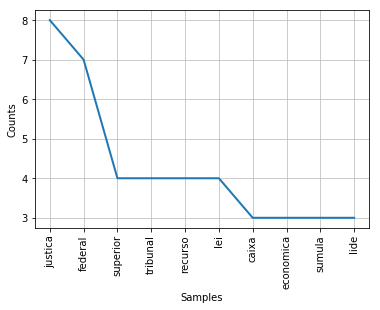

In [21]:
fdist.plot(10,cumulative=False)

In [22]:
df['EMENTA_NORM'] = df['EMENTA'].apply(lambda e: normalizar(e))

In [32]:
import nltk

nltk.download('rslp')

from nltk.stem import RSLPStemmer

stemmer = RSLPStemmer()

def radical(texto):
    words = [stemmer.stem(word) for word in texto.split()]
    return ' '.join(words)

[nltk_data] Downloading package rslp to /home/piantino/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [33]:
df['EMENTA_STEM'] = df['EMENTA_NORM'].apply(lambda e: radical(e))

In [34]:
df['EMENTA_STEM'][1]

'apelaca civel aca rescisa contrat cumul indenizaca perd dan reintegraca poss contrat particul compromiss compr vend bem imovel inadimple atribu promit compr reconvenca imovel adquir final exploraca bar wisk alv funcion deneg municipal raza inadequaca zone urban pretend condenaca promit vend pag indenizaca desp suport edificaca imovel inexistenc notificaca premonit conditi sin qua non demand extint resoluca merit form art inc vi codig process civil recurs part autor defend efet constituica mor contrat inocorrenc notificaca avis receb ar entreg destinat ebct ausenc requisit obje process val regul demand imovel urban terren frut desmembr aplicaca lei exeges sumul superi tribun jus recurs conhec desprov term pacif jurisprudenc dest egreg cort desfaz contrat promess compr vend exig prev interpelaca dev constituil mor preced mat consolid enunci sumul stj segund falt registr compromiss compr vend imovel dispens prev interpelaca constitu mor dev necess prev notificaca configuraca mor trat mod

In [35]:
df.to_csv('../data/ementas_pre-processadas.csv')